In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from adjustText import adjust_text
from scipy.stats import ttest_ind

In [8]:
sample_keep = ["run_accession", "subset", "status", "type"]

In [9]:
def test_vs_ref(x, y, ref="CTRL"):
    groups = x[x != ref].unique()
    tests = [pd.Series(ttest_ind(y[x == ref], y[x == g],
                                 equal_var=False)) for g in groups]
    tests = pd.DataFrame(tests)
    tests.columns = ["statistic", "pvalue"]
    tests["group"] = groups
    return tests

In [10]:
def box_jitter(x, y, **kwargs):
    sns.boxplot(x=x, y=y, color="white")
    sns.stripplot(x=x, y=y, color="black")
    print(test_vs_ref(x, y))

In [11]:
def export_rates_plot(fluxes, groups, samples):
    dfs = []
    for name, filt in groups.items():
        df = fluxes[fluxes.reaction.str.contains(filt)].copy()
        res = samples.copy()
        df = df.groupby(["sample", "compartment"]).tot_flux.sum().reset_index()
        res["flux"] = df.groupby("sample").tot_flux.sum().abs()
        res["metabolite"] = name
        dfs.append(res)
    fluxes = pd.concat(dfs)
    fluxes.loc[fluxes.status == "ND", "status"] = ""
    fluxes["name"] = fluxes.status + " " + fluxes.type.fillna("")
    fluxes.name = fluxes.name.str.strip()
    fluxes = fluxes.sort_values("name")
    grid = sns.FacetGrid(fluxes, col="subset", row="metabolite",
                         sharey=False, sharex=False)
    g = grid.map(box_jitter, "name", "flux", color="white")
    return g

In [12]:
#obtain media from all communities (the docs are obtained by running the micom_syn_data)
media = pd.read_csv("./data/minimal_media_scan.csv", index_col=0).fillna(0.0)
media["sample"] = media.index
media = media.melt(id_vars="sample", var_name="reaction", value_name="flux")

#This file has already been generated, but is a list of all metabolites in Recon2.2 (for more reference, check the file)
metabolites = pd.read_csv("./data/metabolites.csv", index_col=0)
media["id"] = media.reaction.str.lstrip("EX_")
metabolites['id']=metabolites.index
media

,sample,reaction,flux,id
0,com_0.180.520.3,EX_arg_L_m,0.009519,arg_L_m
1,com_0.320.470.21,EX_arg_L_m,0.009519,arg_L_m
2,com_0.840.080.09,EX_arg_L_m,0.009519,arg_L_m
3,com_0.240.530.23,EX_arg_L_m,0.009519,arg_L_m
4,com_0.110.390.5,EX_arg_L_m,0.009519,arg_L_m
...,...,...,...,...
5883,com_0.470.220.32,EX_urea_m,0.000000,urea_m
5884,com_0.470.360.17,EX_urea_m,0.000000,urea_m
5885,com_0.480.50.02,EX_urea_m,0.000000,urea_m
5886,com_0.090.390.52,EX_urea_m,0.000000,urea_m


In [13]:
#file also generted by running micom_syn_data
media = pd.merge(media, metabolites, on="id")
samples = pd.read_csv("./data/Recent_scan.csv")[sample_keep]
samples = samples.rename(columns={"run_accession": "sample"})
media = pd.merge(media, samples, on="sample")
media

,sample,reaction,flux,id,fullName,chargedFormula,subset,status,type
0,com_0.180.520.3,EX_arg_L_m,0.009519,arg_L_m,L-argininium(1+),C6H15N4O2,MCF7,OK,spheroid_syn
1,com_0.180.520.3,EX_chol_m,0.004556,chol_m,choline,C5H14NO,MCF7,OK,spheroid_syn
2,com_0.180.520.3,EX_co2_m,-0.226122,co2_m,carbon dioxide,CO2,MCF7,OK,spheroid_syn
3,com_0.180.520.3,EX_cys_L_m,0.001234,cys_L_m,L-cysteine,C3H7NO2S,MCF7,OK,spheroid_syn
4,com_0.180.520.3,EX_h2o_m,-0.204566,h2o_m,water,H2O,MCF7,OK,spheroid_syn
...,...,...,...,...,...,...,...,...,...
5435,com_0.570.270.15,EX_thr_L_m,0.008285,thr_L_m,L-threonine,C4H9NO3,MCF7,OK,spheroid_syn
5436,com_0.570.270.15,EX_tyr_L_m,0.004230,tyr_L_m,L-tyrosine,C9H11NO3,MCF7,OK,spheroid_syn
5437,com_0.570.270.15,EX_val_L_m,0.009342,val_L_m,L-valine,C5H11NO2,MCF7,OK,spheroid_syn
5438,com_0.570.270.15,EX_h_m,0.000000,h_m,proton,H,MCF7,OK,spheroid_syn


In [14]:
#Generate a heatmap of import/export of metabolites per community (only media metabolites)
mat = media.pivot_table(index="id",columns="sample", values="flux")
mat = mat.apply(lambda x: x / x.abs().max(), axis=1)
g = sns.clustermap(mat, cmap="RdBu", figsize=(40, 42))
g.ax_heatmap.set_xlabel("")
g.ax_heatmap.set_ylabel("")
plt.savefig("./figures/media_scan.png")
plt.close()

In [15]:
fluxes = pd.read_csv("./data/minimal_fluxes_scan.csv.gz", compression="gzip")
fluxes = fluxes.melt(id_vars=["sample", "compartment"], var_name="reaction",
                     value_name="flux")
fluxes = fluxes[fluxes.reaction.str.startswith("EX_") &
                (fluxes.compartment != "medium")].fillna(value=0.0)
fluxes["taxa"] = fluxes.compartment + "_" + fluxes["sample"]
fluxes

,sample,compartment,reaction,flux,taxa
485376,com_0.180.520.3,A,EX_2hb_LPAREN_e_RPAREN_,0.0,A_com_0.180.520.3
485377,com_0.180.520.3,B,EX_2hb_LPAREN_e_RPAREN_,0.0,B_com_0.180.520.3
485378,com_0.180.520.3,C,EX_2hb_LPAREN_e_RPAREN_,0.0,C_com_0.180.520.3
485380,com_0.320.470.21,A,EX_2hb_LPAREN_e_RPAREN_,0.0,A_com_0.320.470.21
485381,com_0.320.470.21,B,EX_2hb_LPAREN_e_RPAREN_,0.0,B_com_0.320.470.21
...,...,...,...,...,...
2541561,com_0.090.390.52,B,EX_pe_hs_LPAREN_e_RPAREN_,0.0,B_com_0.090.390.52
2541562,com_0.090.390.52,C,EX_pe_hs_LPAREN_e_RPAREN_,0.0,C_com_0.090.390.52
2541564,com_0.570.270.15,A,EX_pe_hs_LPAREN_e_RPAREN_,0.0,A_com_0.570.270.15
2541565,com_0.570.270.15,B,EX_pe_hs_LPAREN_e_RPAREN_,0.0,B_com_0.570.270.15


In [16]:
samples = pd.read_csv("./data/Recent_scan.csv")[
    ["run_accession", "status", "subset", "type"]]
samples = samples.rename(columns={"run_accession": "sample"})
samples.index = samples["sample"]
genera = pd.read_csv("./data/species_reduc_scan.csv")

In [17]:
genera.name = genera.name.replace(r"[^A-Za-z0-9_\s]", "", regex=True)
genera.name = genera.name.replace(r"\s+", "_", regex=True)
genera["taxa"] = genera.name + "_" + genera["samples"]
genera

,samples,name,reads,relative,genus,taxa
0,com_0.180.520.3,A,1,0.184714,A,A_com_0.180.520.3
1,com_0.180.520.3,B,1,0.517573,B,B_com_0.180.520.3
2,com_0.180.520.3,C,1,0.297714,C,C_com_0.180.520.3
3,com_0.320.470.21,A,1,0.320366,A,A_com_0.320.470.21
4,com_0.320.470.21,B,1,0.471315,B,B_com_0.320.470.21
...,...,...,...,...,...,...
763,com_0.090.390.52,B,1,0.390977,B,B_com_0.090.390.52
764,com_0.090.390.52,C,1,0.518797,C,C_com_0.090.390.52
765,com_0.570.270.15,A,1,0.573913,A,A_com_0.570.270.15
766,com_0.570.270.15,B,1,0.273913,B,B_com_0.570.270.15


In [18]:
fluxes = pd.merge(fluxes, genera, on='taxa')
fluxes["tot_flux"] = fluxes.flux * fluxes.relative
fluxes

,sample,compartment,reaction,flux,taxa,samples,name,reads,relative,genus,tot_flux
0,com_0.180.520.3,A,EX_2hb_LPAREN_e_RPAREN_,0.0,A_com_0.180.520.3,com_0.180.520.3,A,1,0.184714,A,0.0
1,com_0.180.520.3,A,EX_2hb_b,0.0,A_com_0.180.520.3,com_0.180.520.3,A,1,0.184714,A,0.0
2,com_0.180.520.3,A,EX_2hb_m,0.0,A_com_0.180.520.3,com_0.180.520.3,A,1,0.184714,A,0.0
3,com_0.180.520.3,A,EX_2mcit_LPAREN_e_RPAREN_,0.0,A_com_0.180.520.3,com_0.180.520.3,A,1,0.184714,A,0.0
4,com_0.180.520.3,A,EX_2mcit_b,0.0,A_com_0.180.520.3,com_0.180.520.3,A,1,0.184714,A,0.0
...,...,...,...,...,...,...,...,...,...,...,...
307627,com_0.570.270.15,C,EX_bilirub_m,0.0,C_com_0.570.270.15,com_0.570.270.15,C,1,0.152174,C,0.0
307628,com_0.570.270.15,C,EX_co_LPAREN_e_RPAREN_,0.0,C_com_0.570.270.15,com_0.570.270.15,C,1,0.152174,C,0.0
307629,com_0.570.270.15,C,EX_co_b,0.0,C_com_0.570.270.15,com_0.570.270.15,C,1,0.152174,C,0.0
307630,com_0.570.270.15,C,EX_co_m,0.0,C_com_0.570.270.15,com_0.570.270.15,C,1,0.152174,C,0.0


In [19]:
samples.reset_index(drop=True, inplace=True)
fluxes = pd.merge(fluxes, samples, on='sample')
fluxes

,sample,compartment,reaction,flux,taxa,samples,name,reads,relative,genus,tot_flux,status,subset,type
0,com_0.180.520.3,A,EX_2hb_LPAREN_e_RPAREN_,0.0,A_com_0.180.520.3,com_0.180.520.3,A,1,0.184714,A,0.0,OK,MCF7,spheroid_syn
1,com_0.180.520.3,A,EX_2hb_b,0.0,A_com_0.180.520.3,com_0.180.520.3,A,1,0.184714,A,0.0,OK,MCF7,spheroid_syn
2,com_0.180.520.3,A,EX_2hb_m,0.0,A_com_0.180.520.3,com_0.180.520.3,A,1,0.184714,A,0.0,OK,MCF7,spheroid_syn
3,com_0.180.520.3,A,EX_2mcit_LPAREN_e_RPAREN_,0.0,A_com_0.180.520.3,com_0.180.520.3,A,1,0.184714,A,0.0,OK,MCF7,spheroid_syn
4,com_0.180.520.3,A,EX_2mcit_b,0.0,A_com_0.180.520.3,com_0.180.520.3,A,1,0.184714,A,0.0,OK,MCF7,spheroid_syn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343819,com_0.570.270.15,C,EX_bilirub_m,0.0,C_com_0.570.270.15,com_0.570.270.15,C,1,0.152174,C,0.0,OK,MCF7,spheroid_syn
343820,com_0.570.270.15,C,EX_co_LPAREN_e_RPAREN_,0.0,C_com_0.570.270.15,com_0.570.270.15,C,1,0.152174,C,0.0,OK,MCF7,spheroid_syn
343821,com_0.570.270.15,C,EX_co_b,0.0,C_com_0.570.270.15,com_0.570.270.15,C,1,0.152174,C,0.0,OK,MCF7,spheroid_syn
343822,com_0.570.270.15,C,EX_co_m,0.0,C_com_0.570.270.15,com_0.570.270.15,C,1,0.152174,C,0.0,OK,MCF7,spheroid_syn


In [20]:
fluxes.to_csv("./data/total_fluxes_scan.csv", index=False)

In [21]:
production = fluxes[fluxes.tot_flux > 0]
consumption = fluxes[fluxes.tot_flux < 0]

In [22]:
production.to_csv('./data/production_fluxes_scan.csv', index=False)
consumption.to_csv('./data/consumption_fluxes_scan.csv', index=False)

In [23]:
mat = fluxes.pivot_table(index="taxa", columns="reaction", values="flux").fillna(0.0)
taxa = mat.index.str.split("_").str[0]
tsne = TSNE(n_components=2).fit_transform(mat)
tsne = pd.DataFrame(tsne, columns=["x", "y"], index=mat.index)
tsne["taxa"] = taxa
sns.set(font_scale=1.5, style="ticks")
g = sns.FacetGrid(tsne, hue="taxa", height=10, aspect=16/10)
gm = g.map(plt.scatter, "x", "y", alpha=0.25)
means = tsne.groupby(taxa).agg("median").reset_index()
texts = means.apply(lambda df: plt.text(df.x, df.y, df.taxa, alpha=0.65),
                    axis=1)
texts = adjust_text(texts, force_text=(0.02, 0.5),
                    arrowprops=dict(arrowstyle='-|>', alpha=0.5, color="k"))
plt.savefig("./figures/individual_media_scan.png", dpi=200)
plt.close()

In [24]:
tsne

,x,y,taxa
taxa,,,
A_com_0.00.630.37,29.591200,-15.688174,A
A_com_0.010.390.6,29.034445,-15.513019,A
A_com_0.020.330.65,28.314886,-14.945005,A
A_com_0.020.390.6,28.791882,-14.965236,A
A_com_0.020.660.32,28.732132,-14.489173,A
...,...,...,...
C_com_0.710.110.18,-4.018642,-2.616572,C
C_com_0.720.010.28,-8.264421,-0.885897,C
C_com_0.720.130.15,-2.770186,-2.592338,C


In [25]:
mat

reaction,EX_2hb_LPAREN_e_RPAREN_,EX_2hb_b,EX_2hb_m,EX_2mcit_LPAREN_e_RPAREN_,EX_2mcit_b,EX_2mcit_m,EX_34hpp_,EX_34hpp_b,EX_34hpp_m,EX_3aib_D_LPAREN_e_RPAREN_,...,EX_val_L_m,EX_vitd3_LPAREN_e_RPAREN_,EX_vitd3_b,EX_vitd3_m,EX_xmp_LPAREN_e_RPAREN_,EX_xmp_b,EX_xmp_m,EX_xylt_LPAREN_e_RPAREN_,EX_xylt_b,EX_xylt_m
taxa,,,,,,,,,,,,,,,,,,,,,
A_com_0.00.630.37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.000004,-0.000004,0.0,-0.000021,-0.000021,0.0
A_com_0.010.390.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.000020,-0.000020,0.0,-0.000123,-0.000123,0.0
A_com_0.020.330.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.000045,-0.000045,0.0,-0.000179,-0.000179,0.0
A_com_0.020.390.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.000040,-0.000040,0.0,-0.000113,-0.000113,0.0
A_com_0.020.660.32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.000048,-0.000048,0.0,-0.000240,-0.000240,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C_com_0.710.110.18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
C_com_0.720.010.28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
C_com_0.720.130.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0


In [26]:
taxa

Index(['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       ...
       'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'],
      dtype='object', name='taxa', length=744)

In [27]:
fluxes

,sample,compartment,reaction,flux,taxa,samples,name,reads,relative,genus,tot_flux,status,subset,type
0,com_0.180.520.3,A,EX_2hb_LPAREN_e_RPAREN_,0.0,A_com_0.180.520.3,com_0.180.520.3,A,1,0.184714,A,0.0,OK,MCF7,spheroid_syn
1,com_0.180.520.3,A,EX_2hb_b,0.0,A_com_0.180.520.3,com_0.180.520.3,A,1,0.184714,A,0.0,OK,MCF7,spheroid_syn
2,com_0.180.520.3,A,EX_2hb_m,0.0,A_com_0.180.520.3,com_0.180.520.3,A,1,0.184714,A,0.0,OK,MCF7,spheroid_syn
3,com_0.180.520.3,A,EX_2mcit_LPAREN_e_RPAREN_,0.0,A_com_0.180.520.3,com_0.180.520.3,A,1,0.184714,A,0.0,OK,MCF7,spheroid_syn
4,com_0.180.520.3,A,EX_2mcit_b,0.0,A_com_0.180.520.3,com_0.180.520.3,A,1,0.184714,A,0.0,OK,MCF7,spheroid_syn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343819,com_0.570.270.15,C,EX_bilirub_m,0.0,C_com_0.570.270.15,com_0.570.270.15,C,1,0.152174,C,0.0,OK,MCF7,spheroid_syn
343820,com_0.570.270.15,C,EX_co_LPAREN_e_RPAREN_,0.0,C_com_0.570.270.15,com_0.570.270.15,C,1,0.152174,C,0.0,OK,MCF7,spheroid_syn
343821,com_0.570.270.15,C,EX_co_b,0.0,C_com_0.570.270.15,com_0.570.270.15,C,1,0.152174,C,0.0,OK,MCF7,spheroid_syn
343822,com_0.570.270.15,C,EX_co_m,0.0,C_com_0.570.270.15,com_0.570.270.15,C,1,0.152174,C,0.0,OK,MCF7,spheroid_syn


In [ ]:
#Not sure what this does (gets UMAP but not sure how its organized)

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import umap
%matplotlib inline

In [29]:
sns.set(style='white', context='poster', rc={'figure.figsize':(14,10)})

In [30]:
np.random.seed(42)

In [31]:
fit = umap.UMAP()
%time u = fit.fit_transform(mat)

Wall time: 38.5 s


In [32]:
u

array([[7.409496 , 7.493007 ],
       [7.431144 , 7.5217376],
       [7.6209135, 7.77684  ],
       ...,
       [2.3115935, 4.2268715],
       [2.5224812, 4.4019475],
       [3.427458 , 5.080088 ]], dtype=float32)

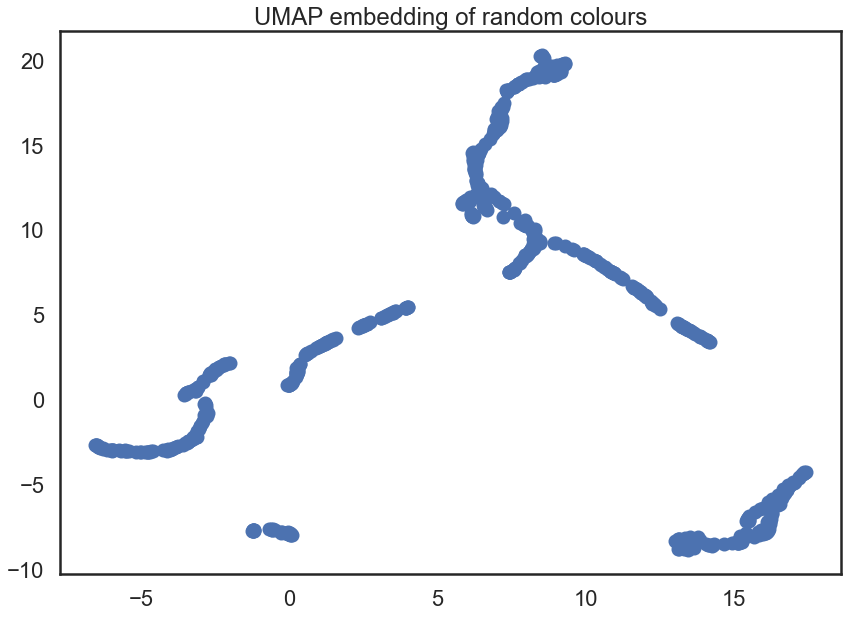

In [33]:
plt.scatter(u[:,0], u[:,1])
plt.title('UMAP embedding of random colours');

In [35]:
def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(mat);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)))
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1])
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], s=100)
    plt.title(title, fontsize=18)

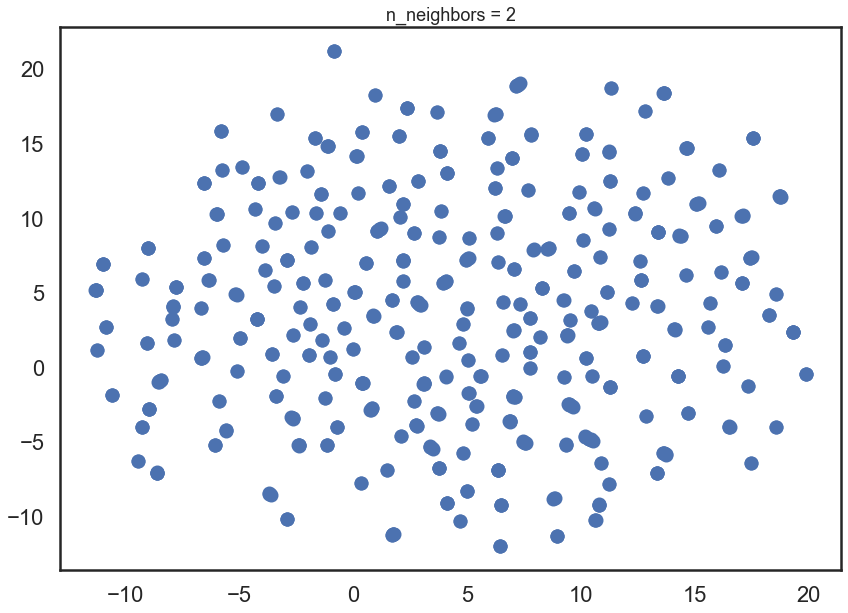

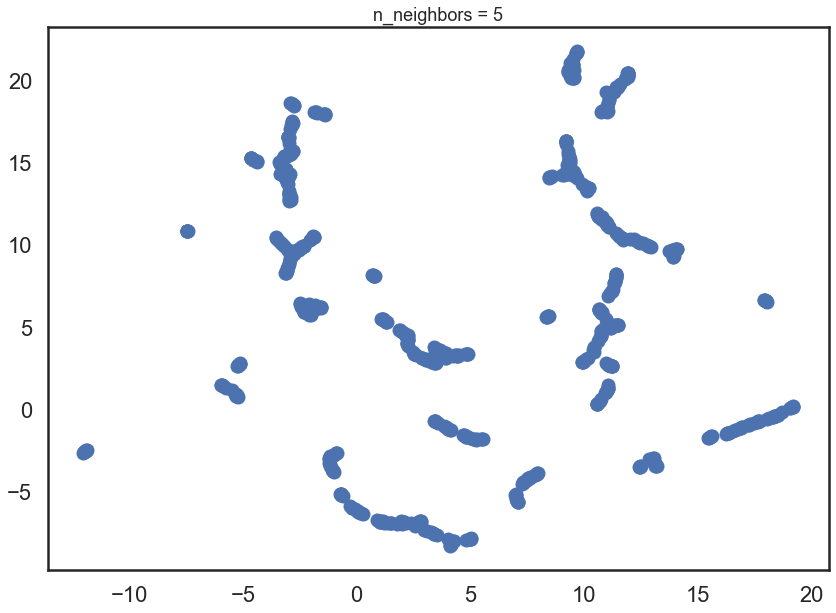

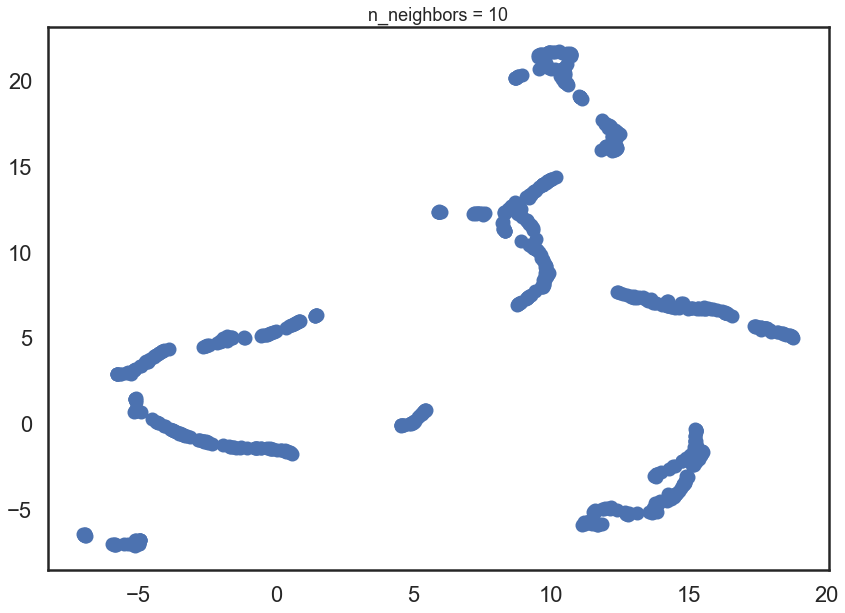

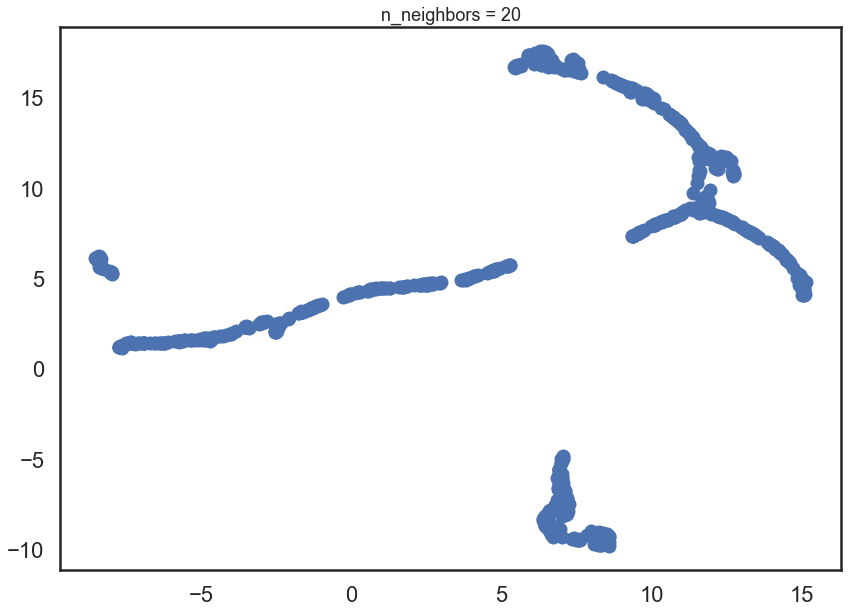

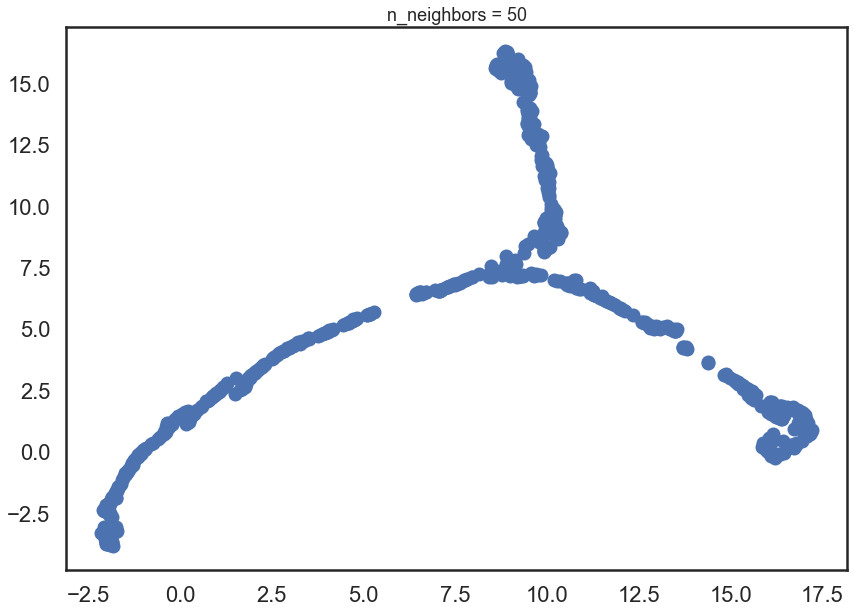

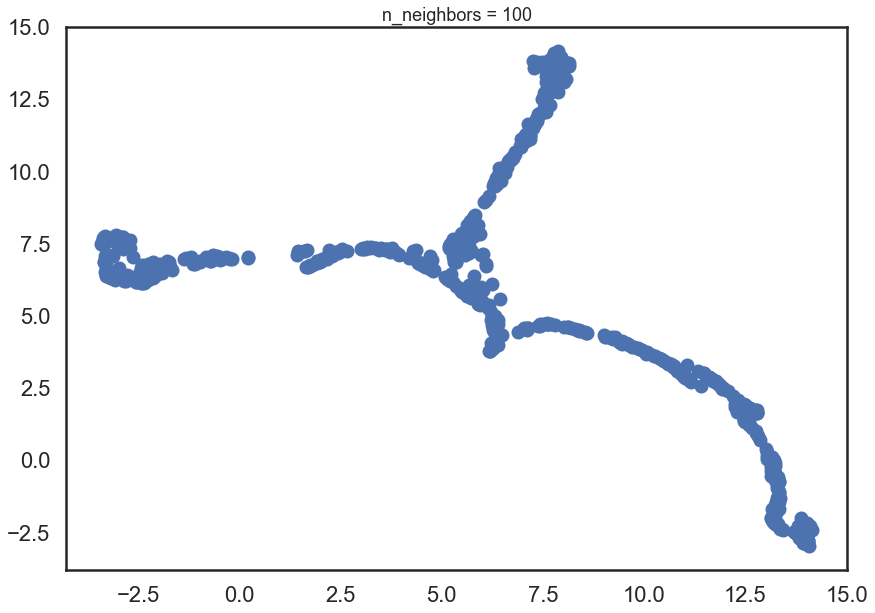

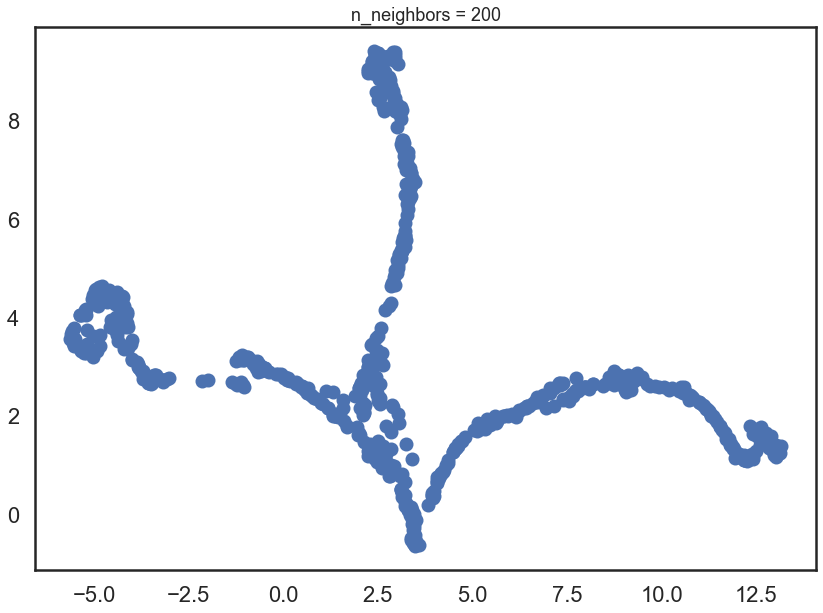

In [36]:
for n in (2, 5, 10, 20, 50, 100, 200):
    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

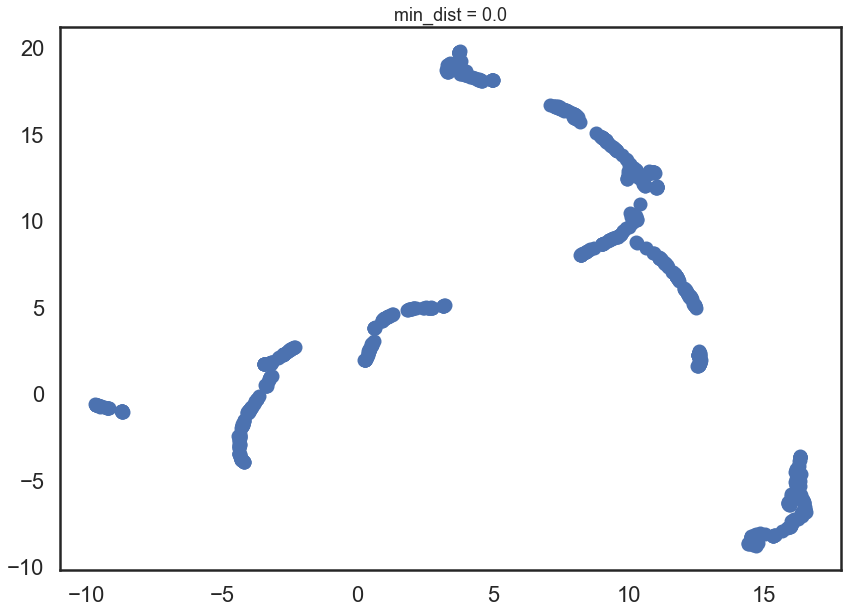

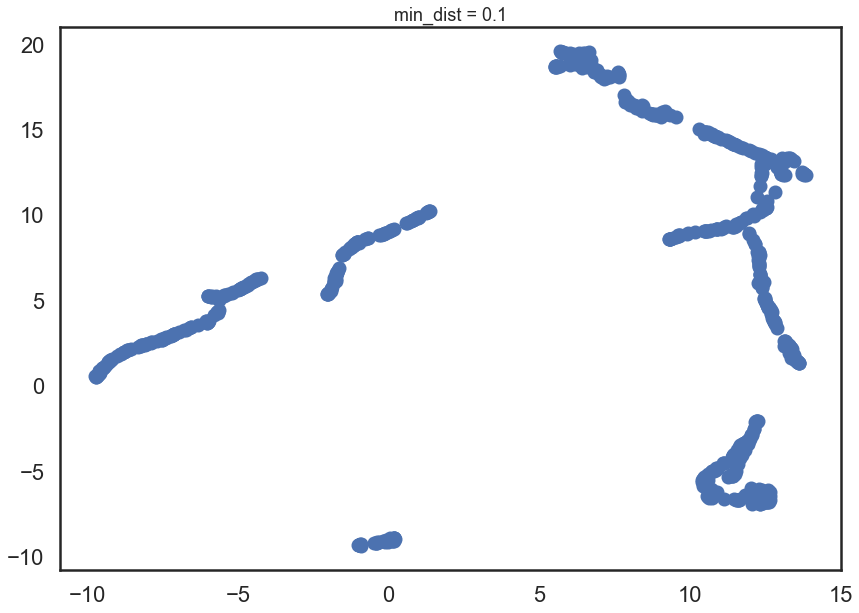

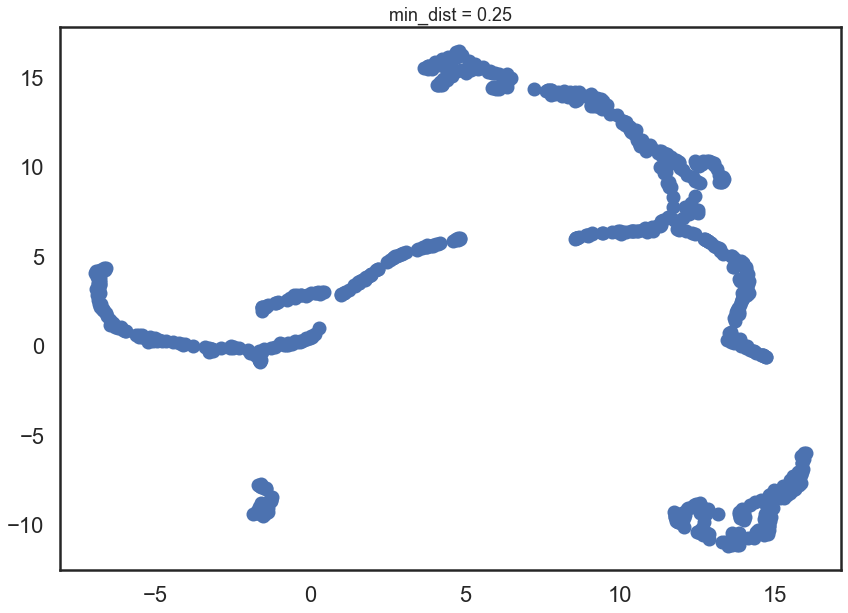

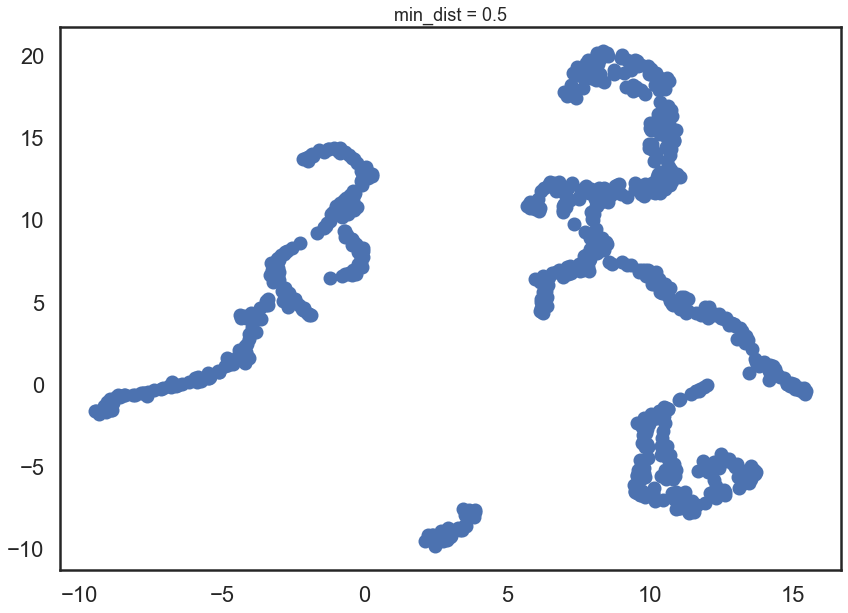

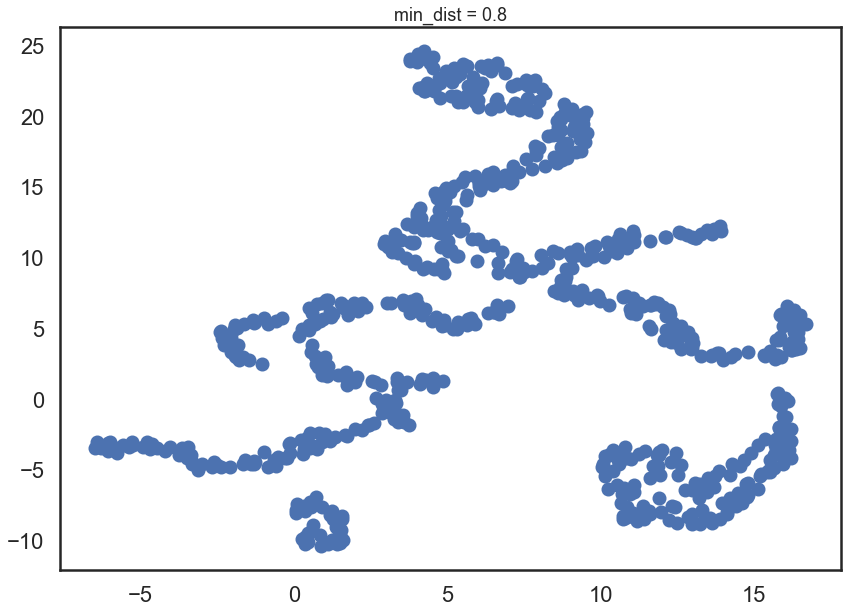

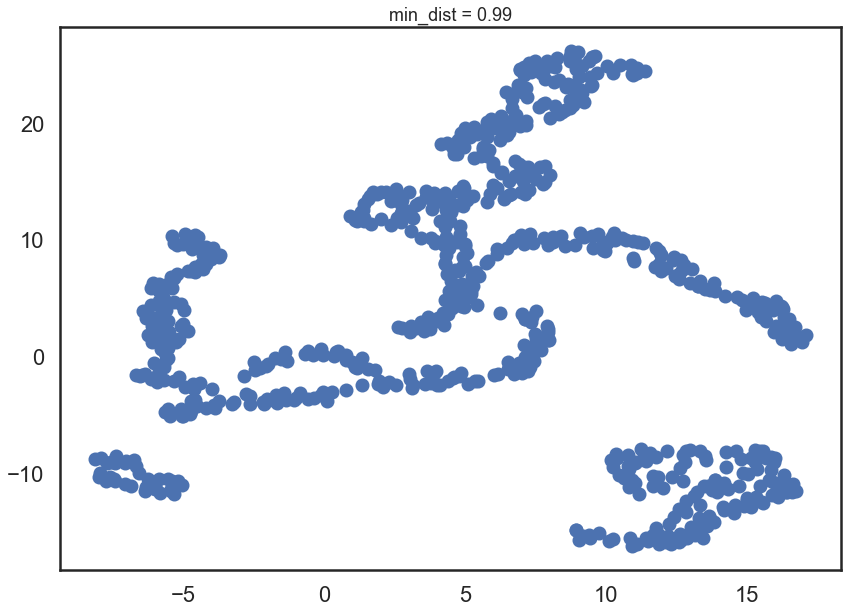

In [37]:
for d in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
    draw_umap(min_dist=d, title='min_dist = {}'.format(d))

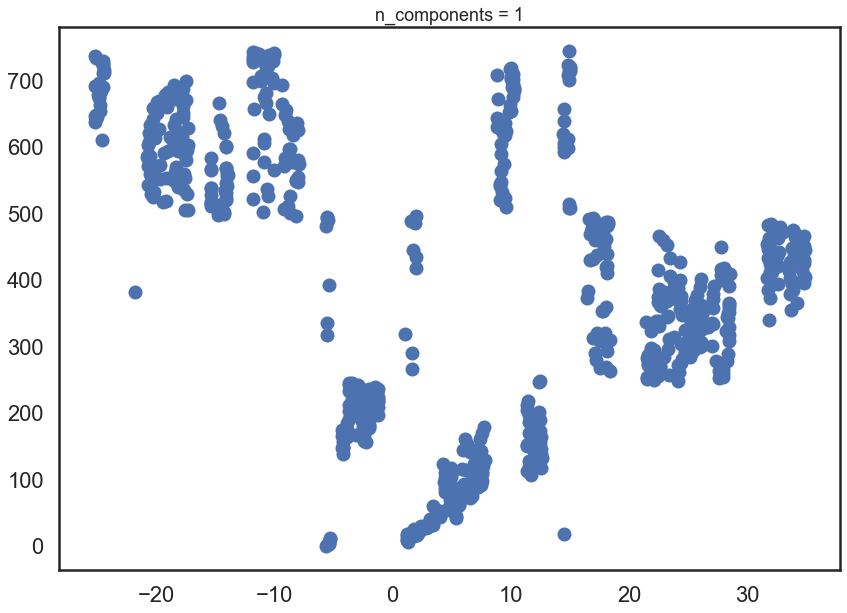

In [38]:
draw_umap(n_components=1, title='n_components = 1')

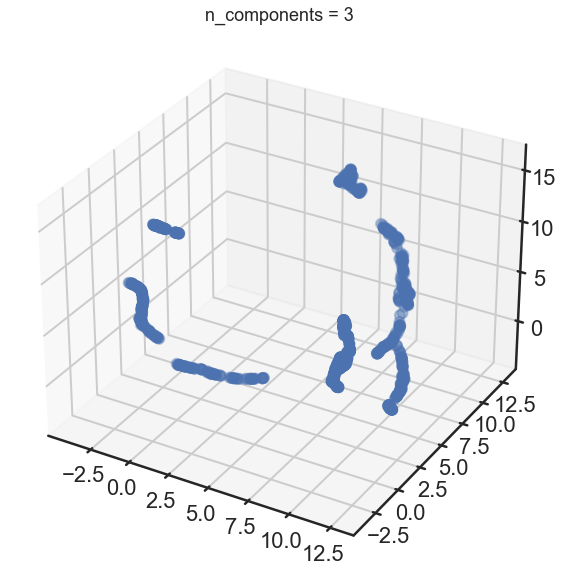

In [39]:
draw_umap(n_components=3, title='n_components = 3')

In [33]:
import numba


In [34]:
@numba.njit()
def red_channel_dist(a,b):
    return np.abs(a[0] - b[0])

In [35]:
@numba.njit()
def hue(r, g, b):
    cmax = max(r, g, b)
    cmin = min(r, g, b)
    delta = cmax - cmin
    if cmax == r:
        return ((g - b) / delta) % 6
    elif cmax == g:
        return ((b - r) / delta) + 2
    else:
        return ((r - g) / delta) + 4

@numba.njit()
def lightness(r, g, b):
    cmax = max(r, g, b)
    cmin = min(r, g, b)
    return (cmax + cmin) / 2.0

@numba.njit()
def saturation(r, g, b):
    cmax = max(r, g, b)
    cmin = min(r, g, b)
    chroma = cmax - cmin
    light = lightness(r, g, b)
    if light == 1:
        return 0
    else:
        return chroma / (1 - abs(2*light - 1))

In [36]:
@numba.njit()
def hue_dist(a, b):
    diff = (hue(a[0], a[1], a[2]) - hue(b[0], b[1], b[2])) % 6
    if diff < 0:
        return diff + 6
    else:
        return diff

@numba.njit()
def sl_dist(a, b):
    a_sat = saturation(a[0], a[1], a[2])
    b_sat = saturation(b[0], b[1], b[2])
    a_light = lightness(a[0], a[1], a[2])
    b_light = lightness(b[0], b[1], b[2])
    return (a_sat - b_sat)**2 + (a_light - b_light)**2

@numba.njit()
def hsl_dist(a, b):
    a_sat = saturation(a[0], a[1], a[2])
    b_sat = saturation(b[0], b[1], b[2])
    a_light = lightness(a[0], a[1], a[2])
    b_light = lightness(b[0], b[1], b[2])
    a_hue = hue(a[0], a[1], a[2])
    b_hue = hue(b[0], b[1], b[2])
    return (a_sat - b_sat)**2 + (a_light - b_light)**2 + (((a_hue - b_hue) % 6) / 6.0)

F:\Programas\Anaconda3\envs\micom\lib\site-packages\umap\umap_.py:2214: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "
F:\Programas\Anaconda3\envs\micom\lib\site-packages\umap\umap_.py:1728: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "
F:\Programas\Anaconda3\envs\micom\lib\site-packages\umap\umap_.py:2214: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


ZeroDivisionError: division by zero

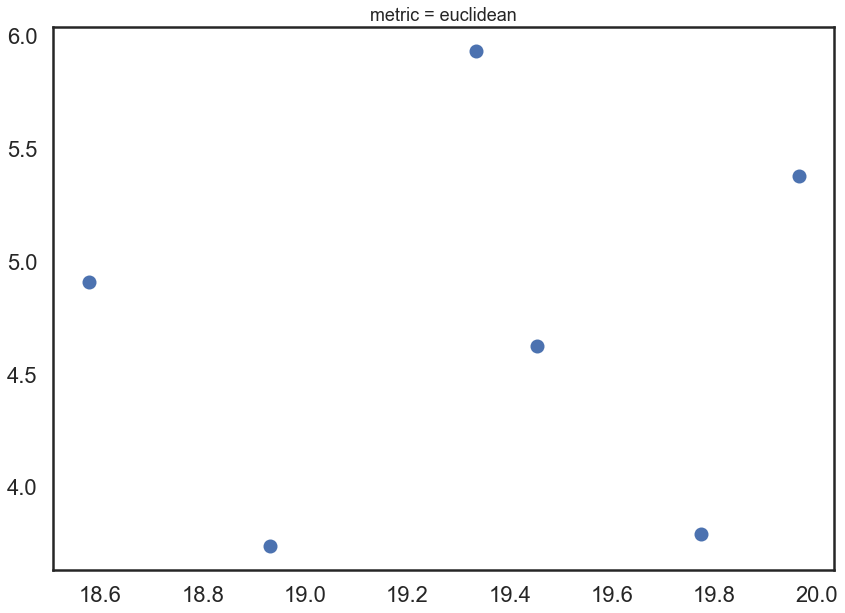

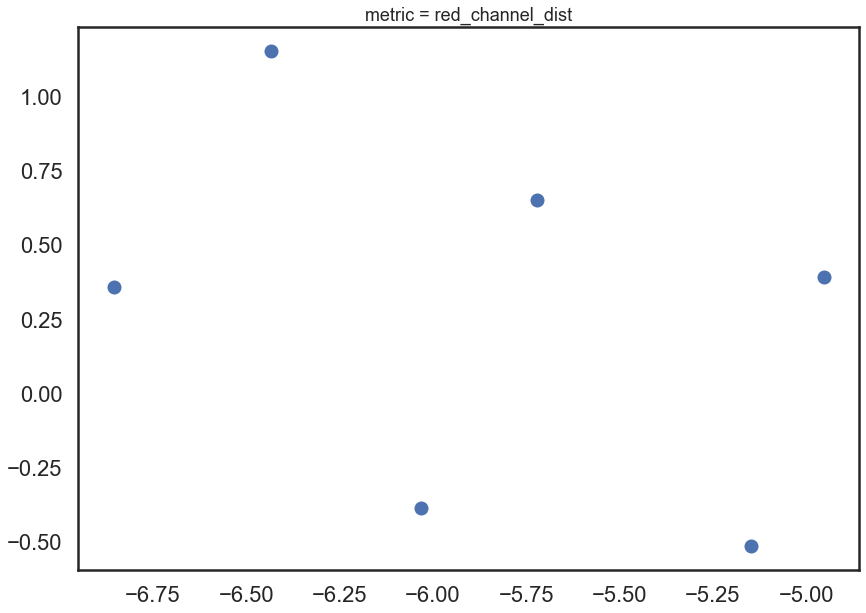

In [37]:
for m in ("euclidean", red_channel_dist, sl_dist, hue_dist, hsl_dist):
    name = m if type(m) is str else m.__name__
    draw_umap(n_components=2, metric=m, title='metric = {}'.format(name))